# Fightin' words

## Measuring distinctive words between corpora

We often want to know which words are used differently in two corpora. There are a bunch of ways to do this. We can train classifiers and examine their feature weights. We can look at mutual information metrics. We could just count the words and see which ones are used more frequently in one corpus than another.

## Fightin' words

But a simple go-to approach that is robust to different underlying word frequencies and makes Bayesian assumptions about how often we would *expect* to see each word, given its frequency in a reference corpus, is Monroe et al.'s [Fightin' words](http://languagelog.ldc.upenn.edu/myl/Monroe.pdf).

Using code originally developed by Jack Hessel (a Cornell PhD grad!), we've provided you with `fightinwords.py`. We'll walk through that code and then see how it performs on real-world data.

The basic algorithm is to measure the observed frequency of each word in two corpora, (optionally) compare that frequency to an empirical prior, and normalize the result using a z-score. The words that have the largest magnitude z-scores (positive or negative) are the ones that tell us the most about the unique vocabulary of each corpus.

In [1]:
import fightinwords as fw
import numpy as np
import os
from   sklearn.feature_extraction.text import CountVectorizer

In [2]:
# test on two novels with 40 more for informative priors

vectorizer = CountVectorizer( # set up a vectorizer
    lowercase=True,
    strip_accents='unicode',
    input='filename',
    encoding='utf-8',
)

# get file names
data_dir = os.path.join('..', 'data', 'texts')
files = os.listdir(data_dir)
bambi_file = 'O-Salten-Bambi-1923.txt'
mme_bovary_file = 'F-Flaubert-Madame_Bovary-1857-M.txt'
if '.DS_Store' in files: files.remove('.DS_Store')
files.remove(bambi_file)
files.remove(mme_bovary_file)
corpus = [os.path.join(data_dir, file) for file in files] # background corpus
samples = [os.path.join(data_dir, file) for file in [bambi_file, mme_bovary_file]]

# read target files by line
bambi_text = [fw.basic_sanitize(line) for line in open(samples[0], 'rt').readlines()]
mme_bovary_text = [fw.basic_sanitize(line) for line in open(samples[1], 'rt').readlines()]

# convenience function to FW display output
def display_fw(data, n=10, name1='corpus one', name2='corpus two'):
    '''Display the indicated number of top terms from fightinwords output.'''
    print("Top terms in", name1)
    for term, score in reversed(data[-n:]):
        print(f"{term:<10} {score:6.3f}")
    print("")
    print("Top terms in", name2)
    for term, score in data[:n]:
        print(f"{term:<10} {score:6.3f}")

In [3]:
# results with a flat (noninformative) prior
# note idiom: pass in text, use default vectorizer
flat = fw.bayes_compare_language(bambi_text, mme_bovary_text)
display_fw(flat)

Vocab size is 1533
Comparing language...
Top terms in corpus one
mother     15.121
he         14.397
there      13.322
just       12.155
can        11.533
you        11.526
now        11.388
don        10.211
they        9.863
ve          9.290

Top terms in corpus two
her        -21.136
the        -20.736
of         -18.484
she        -17.866
on         -9.291
at         -8.932
in         -8.150
for        -6.817
which      -6.611
an         -6.449


Meh. Not *wrong*, but I can't make much of this. Let's try it with an informative prior ...

In [4]:
# learn vocab from *corpus* (not samples) and calculate priors
priors = np.sum(vectorizer.fit_transform(corpus), axis=0).reshape(-1,1)
priors.shape

(53861, 1)

Note that we have changed the input features in this case. We have learned word frequencies on a corpus the DOES NOT include either _Bambi_ or _Mme Bovary_. So we probably won't see "Bambi" as a feature.

In [5]:
# vectorize test books using fitted vectorizer
test_books = vectorizer.transform(samples) # NOT .fit(); want to keep existing vocabulary from priors
print(test_books.shape)

(2, 53861)


In [6]:
# use informative prior
# different idiom: pass in index positions in pre-computed feature matrix
informative = fw.bayes_compare_language(
    l1=[0], 
    l2=[1], 
    features=test_books, 
    cv=vectorizer, 
    prior=priors, 
    #prior_weight=10 <- optional normalize and reweight the data
)
display_fw(informative)

Vocab size is 53861
Comparing language...
Top terms in corpus one
elder       6.438
squirrel    5.134
meadow      4.699
hare        4.088
owl         3.728
auntie      3.726
bushes      3.561
onto        3.518
stag        3.489
magpie      3.311

Top terms in corpus two
emma       -12.470
charles    -12.265
monsieur   -8.382
chemist    -5.474
druggist   -5.268
francs     -4.747
justin     -4.117
madame     -4.046
berthe     -3.478
the        -3.423


## Plotting results

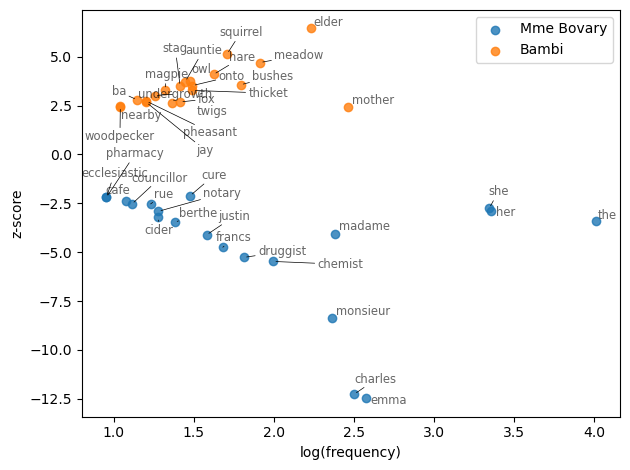

In [7]:
from   adjustText import adjust_text # pretty, but not included with class environment
                                     # conda install -c conda-forge adjusttext 
import matplotlib.pyplot as plt
import pandas as pd

# convert to dataframe for convenience
df = pd.DataFrame(test_books.toarray(), columns=vectorizer.get_feature_names_out())

num_words_to_plot = 20 # number of most distinctive words to plot from each corpus

 # manage data for plotting
frequencies = []
zscores = []
words = []
for word, z_score in informative:
    count = df[word].sum()
    if count > 0:
        zscores.append(z_score)
        words.append(word)
        frequencies.append(count)

# plot result
texts = []
fig, ax = plt.subplots(1,1)
ax.scatter(
    np.log10(frequencies[:num_words_to_plot]), 
    zscores[:num_words_to_plot], 
    alpha=0.8, 
    label="Mme Bovary"
)
ax.scatter(
    np.log10(frequencies[-num_words_to_plot:]), 
    zscores[-num_words_to_plot:], 
    alpha=0.8, 
    label="Bambi"
)
for i in range(-num_words_to_plot, num_words_to_plot):
    texts.append(ax.text(np.log10(frequencies[i]), zscores[i], words[i], size='small', alpha=0.6))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.xlabel('log(frequency)')
plt.ylabel('z-score')
plt.legend()
plt.tight_layout()
plt.show()

## News data

In [8]:
# read data from disk and examine
import re

news = pd.read_csv(os.path.join('..', 'data', 'news_text.csv.gz'))

# a function to get rid of datelines at the start of articles
#  matches one or more hyphens or colons in first 40 chars,
#  drops everything before that match (plus the match itself)
pattern = '[-:]+ '
matcher = re.compile(pattern) # compiled regexs are faster

def remove_dateline(text, matcher=matcher):
    '''
    Remove source names and datelines from a text string
    If there is a hyphen or colon in the first 40 characters, 
      drops everything before the hyphen(s)/colon(s)
    If no hyphen/colon, do nothing
    Return processed string
    '''
    result = matcher.search(text, endpos=40)
    if result:
        return text[result.end():]
    else:
        return text

# clean article text
news['body'] = news['body'].apply(remove_dateline)

In [9]:
num_holdout_articles = 20000

vec = CountVectorizer(
    lowercase=True,
    strip_accents='unicode',
    input='content',
    encoding='utf-8',
)

# calculate priors on non-holdout volumes
priors = np.sum(vec.fit_transform(news.body.iloc[num_holdout_articles:]), axis=0).reshape(-1,1)
priors.shape

(57875, 1)

In [10]:
sports = news.iloc[:num_holdout_articles].loc[news.label=='Sports', ['body']]
other = news.iloc[:num_holdout_articles].loc[~(news.label=='Sports'), ['body']]
result = fw.bayes_compare_language(
    l1=[j for i, j in sports.itertuples()], 
    l2=[j for i, j in other.itertuples()], 
    cv=vec, 
    prior=priors
)

Vocab size is 57875
Comparing language...


In [11]:
display_fw(result, n=10, name1='sports', name2='other')

Top terms in sports
39          9.281
season      8.134
cup         8.120
league      8.102
night       7.594
team        7.417
his         7.392
victory     7.276
game        7.262
coach       7.040

Top terms in other
us         -8.665
lta        -7.274
its        -7.033
said       -6.039
email      -5.784
companys   -5.625
worlds     -5.598
walmart    -5.282
countrys   -5.258
inc        -4.954


In [12]:
print(f"Words in prior: {np.sum(priors):>10}")
print(f"Words in samples: {np.sum(vec.transform(news.body.iloc[:num_holdout_articles])):>8}")

Words in prior:    3221236
Words in samples:   597077


In [13]:
# what's up with '39'?
sports.loc[sports.body.str.contains('39')]

,body
3,Miami Dolphins owner Wayne Huizenga and presid...
15,It was a fight that was to receive national ex...
26,Johnny Damon speaks the truth. Quoth the hair...
36,Receiver Eric Moulds is all for team owner Ral...
41,Arsenal #39;s 100 per cent record in the Premi...
...,...
19937,Michael Anti of the United States won the silv...
19967,Scotland #39;s prospects of qualifying for the...
19971,Favourite Anja Paerson of Sweden won the seaso...
19974,Oklahoma wide receiver Mark Clayton scores a t...


In [14]:
other.loc[other.body.str.contains('39')]

,body
12,The Palestinians have taken a double hit this ...
20,The hardline Democratic Unionist leader Ian Pa...
28,quot;This is completely a part of BT #39;s tr...
44,"Forstmann Little amp; Company, a New York buy..."
50,One of Labor #39;s challenges is to come up wi...
...,...
19970,Shares of food makers were mixed in Monday tra...
19980,Joan Marie Gilbert and her 15-year-old daughte...
19983,The most satisfied new-home buyers in the Wash...
19995,Struggling automotive supplier Visteon Corp. t...


Oh, well that's dumb. Clearly need more/different preprocessing. This is the sort of thing you want to check when you see odd results. That said, I guess sports articles use more apostrophes than do other articles?

In [15]:
# compare without priors
no_priors = fw.bayes_compare_language(
    l1=[j for i, j in sports.itertuples()], 
    l2=[j for i, j in other.itertuples()], 
    cv=vec, 
)
display_fw(no_priors)

Vocab size is 57875
Comparing language...
Top terms in corpus one
his        28.952
season     24.496
night      24.434
game       24.285
the        24.005
he         23.236
team       23.035
win        21.673
victory    21.201
points     16.945

Top terms in corpus two
its        -22.583
said       -21.354
us         -18.299
that       -14.657
of         -12.680
company    -12.627
president  -12.380
people     -10.942
government -10.240
million    -9.987
